In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import unicodedata
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [69]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IkanBalam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [71]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IkanBalam\AppData\Roaming\nltk_data...


True

In [51]:
#Keeping a variable containing the original dataset for unforeseen demands of the dsm (data science method)
disaster_tweets_original = pd.read_csv('train.csv')

In [10]:
disaster_tweets = pd.read_csv('train.csv')

In [13]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [16]:
#Only keeping the columns that are necessary for our NLP sentiment analysis problem
disaster_tweets = disaster_tweets.drop(columns=['id', 'keyword', 'location'])

In [17]:
disaster_tweets.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
disaster_tweets.shape

(7613, 2)

In [24]:
#Sampling one of the texts from the text column to get an overview of the type of texts we will be working with and
#processing
disaster_tweets['text'][9]

"I'm afraid that the tornado is coming to our area..."

In [32]:
#Created function here to remove html tags or anything between '<>'
tag_removal_re = re.compile(r'<[^>]+>')

def remove_tags(txt):
    return tag_removal_re.sub('', txt)

In [33]:
#Created a function that takes a string from a text and preprocesses the string to remove any unnecessary characters
def preprocessor(string):
    #Removes html tags
    clean_string = remove_tags(string)
    
    #Removes punctuations, numbers
    clean_string = re.sub('[^a-zA-Z]', ' ', clean_string)
    
    #Removes single characters
    clean_string = re.sub(r"\s+[a-zA-Z]\s+", ' ', clean_string)
    
    #Removes multiple spaces
    clean_string = re.sub(r'\s+', ' ', clean_string)
    
    return clean_string

In [34]:
#Continuing the preprocessing step of cleaning the text and storing cleaned up text in a new list
clean_text = []
strings = list(disaster_tweets['text'])
for string in strings:
    clean_text.append(preprocessor(string))

In [40]:
#Sampling one of the strings to view our preprocessing efforts
clean_text[9]

'I afraid that the tornado is coming to our area '

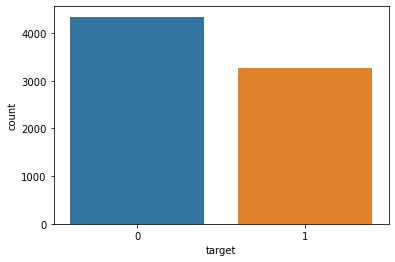

In [45]:
#Getting a count of the distribution of the emergency and non-emergency tweets: non-emergency == 0; emergency == 1
sns.countplot(x='target', data=disaster_tweets);

In [47]:
#Getting a total count for both nonemergency(0) and emergency(1) tweets.
disaster_tweets.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [67]:
def processed_text(text):
    #A function to clean the data. Words that are not identified as stop words are lemmatized after encoding and basic
    #regex are applied
    lem = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
           .encode('ascii', 'ignore')
           .decode('utf-8', 'ignore')
           .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [lem.lemmatize(word) for word in words if word not in stopwords]

In [72]:
#Converting the 'text' column of our dataframe into a list
word_list = processed_text(''.join(str(disaster_tweets['text'].tolist())))

In [74]:
#EDA on the first 15 words of the newly created list of lemmatized words
word_list[:15]

['deed',
 'reason',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'u',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask',
 'canada',
 'resident']

In [75]:
#Creating a bigram from a sampling of the first 15 pairs of the dataset.
bigram_count = pd.Series(nltk.ngrams(word_list, 2)).value_counts()[:15]

In [76]:
print(bigram_count)

(suicide, bomber)         60
(burning, building)       55
(look, like)              49
(body, bag)               48
(youtube, video)          42
(liked, youtube)          42
(northern, california)    41
(cross, body)             39
(oil, spill)              39
(california, wildfire)    36
(suicide, bombing)        33
(mass, murder)            32
(70, year)                31
(natural, disaster)       30
(bomber, detonated)       30
dtype: int64


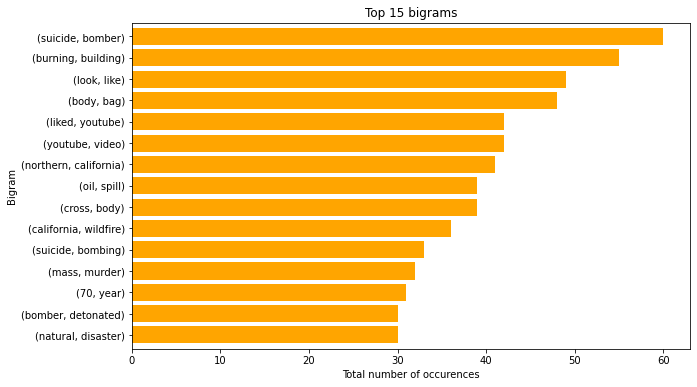

In [81]:
#Horizontal bar graph of the above bigram for EDA and visualization purposes
bigram_count.sort_values().plot.barh(color='orange', width=.8, figsize=(10, 6));
plt.title('Top 15 bigrams')
plt.ylabel('Bigram')
plt.xlabel('Total number of occurences');

In [82]:
#Creating a trigram from a sampling of the first 15 pairs of the dataset
trigram_count = pd.Series(nltk.ngrams(word_list, 3)).value_counts()[:15]

In [83]:
print(trigram_count)

(liked, youtube, video)                    42
(suicide, bomber, detonated)               30
(northern, california, wildfire)           29
(latest, home, razed)                      28
(home, razed, northern)                    28
(pkk, suicide, bomber)                     28
(bomber, detonated, bomb)                  28
(old, pkk, suicide)                        27
(16yr, old, pkk)                           27
(razed, northern, california)              27
(family, affected, fatal)                  26
(40, family, affected)                     26
(family, sue, legionnaire)                 26
(affected, fatal, outbreak)                26
(declares, disaster, typhoondevastated)    25
dtype: int64


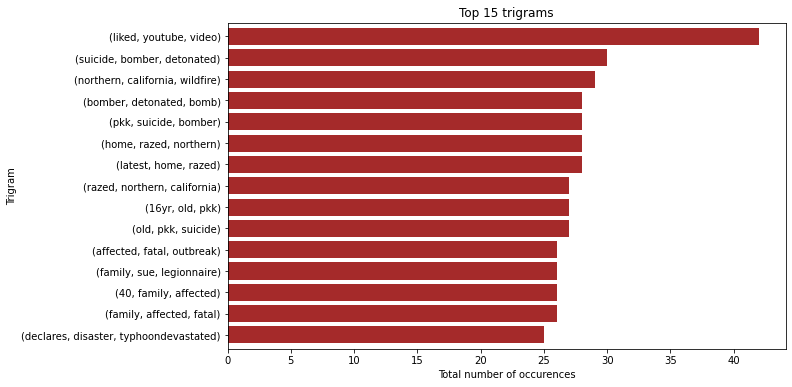

In [94]:
#Horizontal bar graph of the above trigram for EDA and visualization purposes
trigram_count.sort_values().plot.barh(color='brown', width=0.8, figsize=(10, 6));
plt.title('Top 15 trigrams')
plt.ylabel('Trigram')
plt.xlabel('Total number of occurences');